In [1]:
import pandas as pd
import pickle
import numpy as np
from scipy.signal import savgol_filter
import pywt
from scipy.signal import wiener
import copy
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import random
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import Exponentiation
from sklearn.metrics import r2_score
import csv
from sklearn import svm
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_absolute_percentage_error
import warnings
from sklearn.linear_model import RidgeCV
from sklearn.cross_decomposition import PLSRegression
from imblearn.over_sampling import ADASYN
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import CARS1
warnings.filterwarnings("ignore")
random.seed(10)

ModuleNotFoundError: No module named 'scipy'

In [11]:
import os
folder = "C:\\Users\\babu rao\\Desktop\\Code"
filename = os.path.join(folder,"merge_data_gaolitong.csv")
# filename = os.path.join(folder,"data_cur_valid_FUTIAN_label.csv")
# filename_test = os.path.join(folder,"data_cur.csv")
# filename_tmp = os.path.join(folder,"DR2_snv.csv")
# from pytictoc import TicToc
data = pd.read_csv(filename,encoding = 'gbk')
# data_test = pd.read_csv(filename_test)
# data_tmp = pd.read_csv(filename_tmp,header=None)
data[:5]

,Day_idx,wavelength_uv1,wavelength_uv2,wavelength_uv3,wavelength_uv4,wavelength_uv5,wavelength_uv6,wavelength_uv7,wavelength_uv8,wavelength_uv9,...,PH2,DO2,TUR2,AN,COD,TN,TP,KMNO,date_time,备注
0,1,1.507226,1.557360,1.610655,1.666566,1.706439,1.754723,1.782300,1.785203,1.783796,...,6.23,15.24,6.82,0.376,25.948104,21.969,0.063,3.320,2024-07-04 00:00:00,7.3 10:00福田总站水样
1,1,1.347346,1.397334,1.454163,1.508798,1.551478,1.598678,1.636367,1.652027,1.661524,...,6.70,14.97,8.23,0.299,11.976048,22.130,0.050,2.768,2024-07-04 00:00:00,7.3 11:10福田总站水样
2,1,1.358536,1.408090,1.464279,1.508798,1.560296,1.606973,1.644197,1.659264,1.668230,...,6.83,15.25,8.74,0.272,9.048570,22.432,0.074,2.224,2024-07-04 00:00:00,7.3 11:40福田总站水样
3,1,1.336671,1.376312,1.424907,1.477013,1.518036,1.567118,1.606506,1.627891,1.641964,...,7.15,14.81,10.76,0.283,14.105123,22.768,0.054,2.536,2024-07-04 00:00:00,7.3 13:00福田总站水样
4,1,1.447462,1.479640,1.519485,1.553606,1.587639,1.632771,1.660274,1.674081,1.681946,...,7.49,15.55,13.85,0.325,13.972056,20.264,0.054,2.584,2024-07-04 00:00:00,7.3 13:30福田总站水样


In [13]:
configs = pd.read_csv(os.path.join(folder,"configs_gaolitong.csv"))

In [15]:
start = 0
end = len(data)

In [17]:
days = data.values[start:end,0]
# days_test = data_test.values[:,0]
# X1 = data_tmp.values[start:end,0:611]
X1 = data.values[start:end,11:612]
X2 = data.values[start:end,615:1226]
# X1_test = data_test.values[:,1:612]
TUR = data.values[start:end,614]
COD = data.values[start:end,1230]
TN = data.values[10:end,1231]
KMNO = data.values[start:end,1233]
TP = data.values[start:end,1232]
AN = data.values[start:end,1229]
print(f"X1.shape:{X1.shape}, days.shape:{days.shape}, TUR.shape:{TUR.shape}, TN.shape:{TN.shape}, KMNO.shape:{KMNO.shape}, X2.shape:{X2.shape}")

X1.shape:(1230, 601), days.shape:(1230,), TUR.shape:(1230,), TN.shape:(1220,), KMNO.shape:(1230,), X2.shape:(1230, 611)


In [19]:
def wavelet_denoising(data, wavelet, level):
    coeff = pywt.wavedec(data, wavelet, mode='smooth', level=level)
    sigma = np.median(np.abs(coeff[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2*np.log(len(data)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='smooth')

def standardize_data(data):
    mean_val = np.mean(data)
    std_dev = np.std(data)
    standardized_data = (data - mean_val) / std_dev
    return standardized_data

def evaluate(p, t, ranges,bound):
    len_list_level2 = 0
    count1 = 0
    count2 = 0
    for i in range(len(p)):
        if p[i] <= ranges[0] and t[i] <= ranges[0] or ranges[0]<p[i] <= ranges[1] and ranges[0]<t[i] <= ranges[1]:
            count1 += 1
        if t[i] <= ranges[1]:
            len_list_level2 += 1
        else:
            if abs(p[i]-t[i])/t[i] <= bound:
                count2 += 1
#             else:
#                 print(abs(p[i]-t[i])/t[i])
                
    if len_list_level2 == 0:
        res1 = 1
    else:
        res1 = count1/len_list_level2
#         print('level2',count1, len_list_level2)
        
    if (len(p)-len_list_level2) == 0:
        res2 = 1
    else:
        res2 = count2/(len(p)-len_list_level2)
#         print(res2,len(p)-len_list_level2)
    
#     print('count2',count2)
    return res1, res2

In [21]:
X1_smooth = copy.deepcopy(X1)
X1_snv = copy.deepcopy(X1)
for i in range(len(X1)):
#     X1_smooth[i,:] = wiener(X1[i,:], mysize=None, noise=None)
    X1_smooth[i,:] = savgol_filter(X1[i,:], 15, 3)
    X1_smooth[i,:] = wavelet_denoising(X1_smooth[i,:], 'sym4', 2)[1:]
    X1_snv[i,:] = standardize_data(X1_smooth[i,:])

In [90]:
X1_smooth_test = copy.deepcopy(X1_test)
X1_snv_test = copy.deepcopy(X1_test)
for i in range(len(X1_test[1:10,:])):
#     X1_smooth[i,:] = wiener(X1[i,:], mysize=None, noise=None)
    X1_smooth_test[i,:] = savgol_filter(X1_test[i,:], 15, 3)
    X1_smooth_test[i,:] = wavelet_denoising(X1_smooth_test[i,:], 'sym4', 2)[1:]
    X1_snv_test[i,:] = standardize_data(X1_smooth_test[i,:])

NameError: name 'X1_test' is not defined

In [23]:
import math
unique_day = np.unique(days)
unique_day
days_TN = days[10:]
unique_day_TN = np.unique(days_TN)
idx = [i for i in range(len(KMNO)) if not math.isnan(KMNO[i])]
unique_day

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73], dtype=object)

In [92]:
unique_day_test = np.unique(days_test)
len(unique_day_test)

NameError: name 'days_test' is not defined

# KMNO Best: GPR, Lasso

X shape (1230, 601)
round 1
601
(1, 601)
[  9  10  71 225  72  73  12 369  89 159 267 283  70  90  11  88 215 221
  54  53  55 109 370  52 175  74 110 487 176 365  91  87 461  16 293 219
 284 108  56 457  51 503  30 213 239 393 391 553 462 187 111  29  13 341
 473 486 441 222 381 242 270 279 526  60 116 216  19 115 241  17 527  61
 315 287 226 269 314 294  69 469 504 177  92 228 101 245 353 160 227 182
 474 263 286 482 318  86  33 481 107 201 532 364 117 299 202 491 271 523
 394 349 374 224 319 102 366 183 114 181 542   8 423 373 289  20 121 440
 415 122 424 282 368 470  59 385 531 456 207 525 533 390 460 409  34 352
 313  75 212  50 280 522 541 243 554   6 172 158 317 549 386 543 483 463
 358 264 538 163 488 508 330 435 218 354   7  82 257 380 151 260 189 584
 171 528 169 509 414 537 444 246  83 583  62 539 397 359 197 371 458 485
 290 273 292 146 123  41 331 275 431 310 468  81 325 410 186 168 266  15
 203 443 147 492 206 357 434 581 261 288 274 490  31 100 552  42 311 259
 436 375 1

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

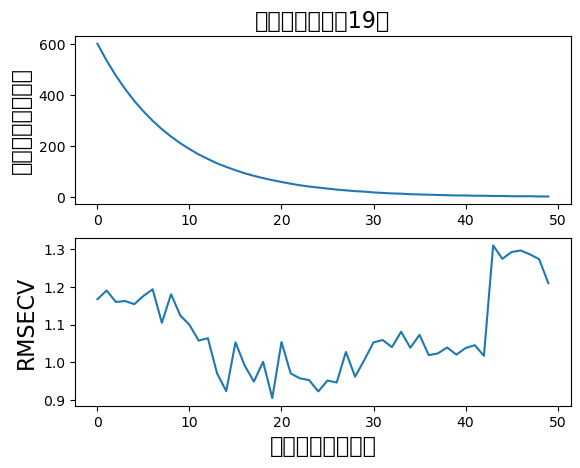

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

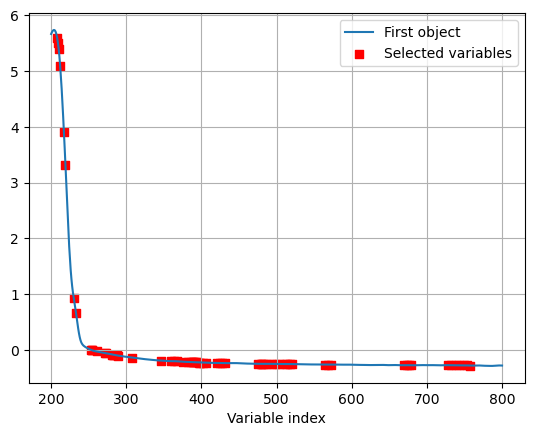

In [31]:
import math
idx = [i for i in range(len(KMNO)) if not math.isnan(KMNO[i])]
lis, minRMSECV,rindex = CARS1.CARS_Cloud(X1_snv[idx,:],KMNO[idx],days[idx],800)

In [29]:
lis

array([ 14,  42,  55,  56,  65,  66,  67, 176, 182, 210, 230, 231, 232,
       256, 261, 287, 298, 299, 317, 321, 327, 331, 369, 373, 401, 418,
       425, 426, 448, 457, 459, 460, 461, 474, 478, 481, 482, 490, 497,
       517, 522, 524, 540, 542, 556, 557, 558, 560, 590, 591, 592, 593],
      dtype=int64)

In [220]:
import math
rng = np.random.RandomState(1)
days = data.values[idx,0]
kmno_type = []
for i in range(len(KMNO)):
    if KMNO[i] >=4:
        kmno_type.append(3)
    else:
        kmno_type.append(1)
kmno_type = np.array(kmno_type)


random.seed(10)

res_train1 = []
res_train2 = []
res_train3 = []
res_train4 = []
res_train5 = []
res_train6 = []
idx = [i for i in range(len(KMNO)) if not math.isnan(KMNO[i])]
# in_data = X1_snv[idx,:][:,lis]
in_data = X1_snv[idx,:][:,lis]
target = KMNO[idx]
data_type = kmno_type[idx]
days = data.values[start:end,0]
unique_day = np.unique(data.values[start:end,0][idx])


best_score1 = -100
best_model1 = None
best_score2 = -100
best_model2 = None
best_score3 = -100
best_model3 = None
best_score4 = -100
best_model4 = None
best_score5 = -100
best_model5 = None
best_score6 = -100
best_model6 = None


for i in range(len(unique_day)):
    train_idx = [j for j in range(len(days[idx])) if days[idx][j]!=unique_day[i]]
    test_idx = [j for j in range(len(days[idx])) if days[idx][j]==unique_day[i]]
    XTrain = in_data[train_idx,:]
    yTrain = target[train_idx]
    print(train_idx, test_idx)
    try:
        X_res, y_res = ada.fit_resample(np.concatenate((XTrain,yTrain.reshape(-1,1)),axis=1),data_type[train_idx])
        XTrain = X_res[:,:-1]
        yTrain = X_res[:,-1]
        print(XTrain.shape,yTrain.shape)
    except:
        print('failed at',i)

    clf1 = Ridge(alpha=configs['KMNO1'].values[0],solver='lbfgs',positive=True)
    clf1.fit(XTrain, yTrain)

    clf2 = linear_model.Lasso(alpha=configs['KMNO2'].values[0])
    clf2.fit(XTrain, yTrain)
    
    pls = PLSRegression(
            n_components=rindex+1, scale=True, max_iter=500, tol=1e-06, copy=True
        )
    pls.fit(XTrain, yTrain)
    
    regr1 = AdaBoostRegressor(
    clf1, n_estimators=300, random_state=rng
).fit(XTrain, yTrain)
    
    regr2 = AdaBoostRegressor(
    clf2, n_estimators=300, random_state=rng
).fit(XTrain, yTrain)
    
    res_train1.extend(clf1.predict(in_data[test_idx,:]))
    res_train2.extend(clf2.predict(in_data[test_idx,:]))
    res_train3.extend(pls.predict(in_data[test_idx,:]).reshape(1,-1).tolist()[0])
    res_train5.extend(regr1.predict(in_data[test_idx,:]))
    res_train6.extend(regr2.predict(in_data[test_idx,:]))
    
    gpr = GaussianProcessRegressor(
            kernel=1.0 * RationalQuadratic(length_scale=1, alpha=1) + WhiteKernel(1e-1),
            random_state=0,
            optimizer="fmin_l_bfgs_b",
            n_restarts_optimizer=10,
        )
    gpr.fit(XTrain, yTrain)
    res_train4.extend(gpr.predict(in_data[test_idx,:]))
    if gpr.score(XTrain, yTrain) > best_score4:
        best_score4 = gpr.score(XTrain, yTrain)
        best_model4 = gpr
    
    if clf1.score(XTrain, yTrain) > best_score1:
        best_score1 = clf1.score(XTrain, yTrain)
        best_model1 = clf1
    if clf2.score(XTrain, yTrain) > best_score2:
        best_score2 = clf2.score(XTrain, yTrain)
        best_model2 = clf2
    if pls.score(XTrain, yTrain) > best_score3:
        best_score3 = pls.score(XTrain, yTrain)
        best_model3 = pls
    if regr1.score(XTrain, yTrain) > best_score5:
        best_score5 = regr1.score(XTrain, yTrain)
        best_model5 = regr1
    if regr2.score(XTrain, yTrain) > best_score6:
        best_score6 = regr2.score(XTrain, yTrain)
        best_model6 = regr2
    

print(best_score1,best_score2, best_score3, best_score4,best_score5,best_score6)

test_idx [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
failed at 0
test_idx [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
failed at 1
test_idx [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
failed at 2
test_idx [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
failed at 3
test_idx [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
failed at 4
test_idx [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]
failed at 5
test_idx [75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
failed at 6
test_idx [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
failed at 7
test_idx [105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
failed at 8
test_idx [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]
failed at 9
test_idx [135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]
failed at 10
test_idx [150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164]
failed at 11
test_idx [165, 166,

In [141]:
import lightgbm as lgb  
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
import warnings 
warnings.filterwarnings('ignore')
from lightgbm import LGBMRegressor


random.seed(10)
rng = np.random.RandomState(1)

res_train = []


best_score = -100
best_model = None

for i in range(len(unique_day)):
    train_idx = [j for j in range(len(days[idx])) if days[idx][j]!=unique_day[i]]
    test_idx = [j for j in range(len(days[idx])) if days[idx][j]==unique_day[i]]
    XTrain = in_data[train_idx,:]
    yTrain = target[train_idx]
    try:
        X_res, y_res = ada.fit_resample(np.concatenate((XTrain,yTrain.reshape(-1,1)),axis=1),kmno_type[train_idx])
        XTrain = X_res[:,:-1]
        yTrain = X_res[:,-1]
        print(XTrain.shape,yTrain.shape)
    except:
        print('failed at',i)
    scaler = StandardScaler() 
    scaler.fit(XTrain) 
    XTrain = scaler.transform(XTrain) 
    XVal = scaler.transform(in_data[test_idx,:])
    train_data = lgb.Dataset(XTrain, label=yTrain)
    test_data = lgb.Dataset(XVal, label=target[test_idx], reference=train_data)
    model = LGBMRegressor(reg_alpha = configs['KMNO1'].values[0],reg_lambda = configs['KMNO2'].values[0],boosting_type = 'dart',metric='rmse',n_estimators=300).fit(XTrain, yTrain)
    res_train.extend(model.predict(XVal))

1139 1
test_idx [977]
failed at 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13260
[LightGBM] [Info] Number of data points in the train set: 1139, number of used features: 52
[LightGBM] [Info] Start training from score 3.350994


In [208]:
res_train11 = res_train1.copy()
res_train22 = res_train2.copy()
res_train33 = res_train3.copy()
res_train44 = res_train4.copy()
res_train55 = res_train5.copy()
res_train66 = res_train6.copy()
res_train0 = res_train.copy()
for i in range(len(res_train11)):
    if res_train11[i] <= 0.5:
        res_train11[i] = random.uniform(0.5, 2)
for i in range(len(res_train22)):
    if res_train22[i] <= 0.5:
        res_train22[i] = random.uniform(0.5,2)
for i in range(len(res_train33)):
    if res_train33[i] <= 0.5:
        res_train33[i] = random.uniform(0.5, 2)
for i in range(len(res_train44)):
    if res_train44[i] <= 0.5:
        res_train44[i] = random.uniform(0.5, 2)
for i in range(len(res_train55)):
    if res_train55[i] <= 0.5:
        res_train55[i] = random.uniform(0.5, 2)
for i in range(len(res_train66)):
    if res_train66[i] <= 0.5:
        res_train66[i] = random.uniform(0.5, 2)
for i in range(len(res_train0)):
    if res_train0[i] <= 0.5:
        res_train0[i] = random.uniform(0.5, 2)

0.2745443143643164
-0.23713545455276797
0.449 0.907563025210084


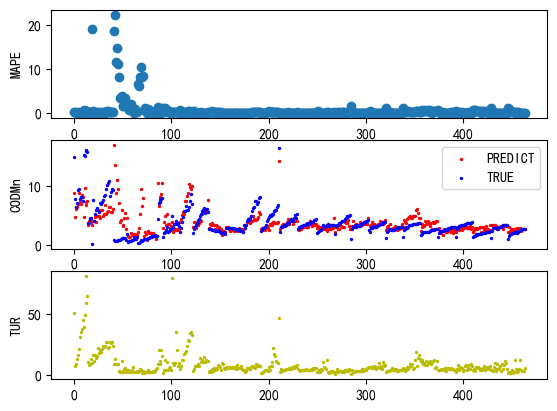

In [215]:
def plot(res, t,TUR, threshold):
    l1 = [res[i] for i in range(len(t)) if t[i]<=threshold]
    l2 = [t[i] for i in range(len(t)) if t[i]<=threshold]
    print(mean_absolute_percentage_error(l1,l2))
    print(r2_score(l1, l2))
    for i in range(1000):
        if evaluate(res, t, [2,4,6,10,15],i/1000)[1] > 0.9:
            print(i/1000,evaluate(res, t, [2,4,6,10,15],i/1000)[1])
            break
    fig = plt.figure()
    plt.subplot(311)
    plt.scatter(list(range(len(l1))),[abs(i-j)/j for i,j in zip(l1,l2)])
    plt.ylabel('MAPE')
    plt.subplot(312)
    plt.scatter(list(range(len(res))),res,s=2,edgecolors='r')
    plt.scatter(list(range(len(t))),t,s=2,edgecolors='b')
    plt.legend(['PREDICT','TRUE'])
    plt.xlabel('Sample ID')
    plt.ylabel('CODMn')
    plt.subplot(313)
    plt.scatter(list(range(len(TUR))),TUR,s=2,edgecolors='y')
    plt.ylabel('TUR')
plot(res_train33[766:],target[766:],TUR[766:],50)

0.26048150833724176
0.0009327244806830448
0.509 0.9019607843137255


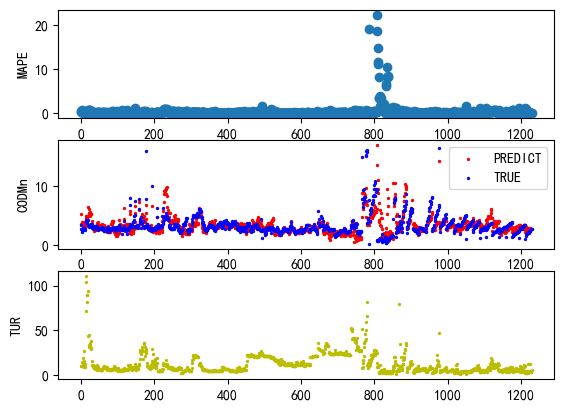

In [214]:
plot(res_train33,target,TUR,50)

In [27]:
res = res_train4
r = [2,4,6,10,15]
count = 0
bad_idx = []
for i in range(len(target)):
    if target[i] <= r[0] and res[i] <= r[0]:
        count += 1
    elif r[0]<target[i] <= r[1] and r[0]<res[i] <= r[1]:
        count += 1
    elif r[1]<target[i] <= r[2] and r[1]<res[i] <= r[2]:
        count += 1
    elif r[2]<target[i] <= r[3] and r[2]<res[i] <= r[3]:
        count += 1
    elif r[3]<target[i] <= r[4] and r[3]<res[i] <= r[4]:
        count += 1
    elif r[4]<target[i] and r[4]<res[i]:
        count += 1
    elif abs(target[i] - res[i])/target[i] < 0.15:
        count += 1
    else:
        print(res[i],target[i])
        bad_idx.append(i)
count/len(res)

7.422432103423489 3.32
4.424508718571815 2.768
4.476961754076001 2.224
5.7529902735941505 2.536
6.23613307505002 2.584
5.9661159836186926 2.616
5.576093885715636 2.96
7.266010661270229 2.88
6.783445163418946 2.96
5.393014300241703 2.8
1.2079939396107875 4.224
7.54735847721895 3.808
6.948004386839784 3.832
6.401331735001804 3.8
6.550534313595563 3.792
6.152289625402773 4.096
6.520065979988431 4.272
4.652703546866178 3.48
4.076295515800666 3.4
4.018506600343244 3.336
5.255525334245249 3.528
3.0434301738550857 1.848
7.670717664819676 4.16
2.437318442104697 1.784
5.504974544463948 6.744
4.601837863556284 8.024
3.0524660898199727 4.328
2.85621054659714 4.072
3.5575584009447994 4.888
3.3907617679160467 5.072
5.849675904290962 7.488
8.112932082362931 3.088
5.043670220370586 6.144
10.667303051510316 7.92
3.6698356882880034 4.72
3.0875182949712325 4.088
4.271881156065319 7.784
7.803050446078487 16.152
8.600326207371836 10.15
3.792561629010379 4.816
4.910760775008384 6.336
3.9979960796836167 5.0

0.8520408163265306

0.4328530633349792
-1.0164301747093982
0.448 0.9024390243902439


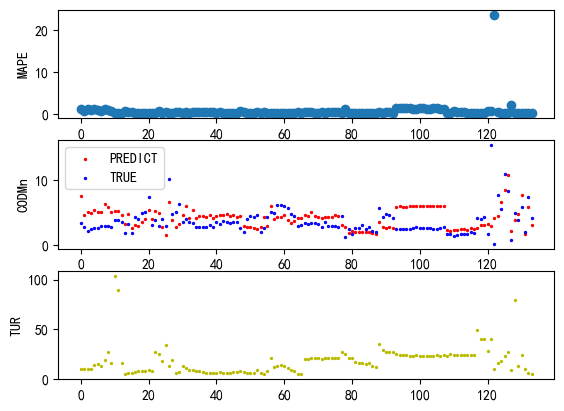

In [121]:
plot([res_train4[i] for i in bad_idx],[target[i] for i in bad_idx],[TUR[i] for i in bad_idx], 50)

6.153668421589235 3.32
4.313008414086017 2.768
4.645466267610221 2.224
4.433242870355529 2.536
4.966684047237759 2.584
5.347854294366244 2.616
5.344425489254424 2.96
5.204070134081537 2.88
4.52772641909348 2.8
4.540737800610137 3.2
3.159021991913773 4.888
4.944407219533808 7.92
3.4551280346838484 4.088
6.1100916502599025 10.15
3.8908398179340336 6.336
3.4370369042332243 6.344
4.287402284691919 3.6
5.48451127838103 4.0
8.027228200921115 4.32
7.893767629018707 4.496
7.528294118380744 4.4
7.533188978594866 4.952
7.528294118380744 4.888
7.600392127826222 4.88
7.552082879076214 4.808
7.600392127826222 5.416
7.720993488483472 4.976
7.80733884996385 4.736
3.805276413225503 4.224
3.384680017048072 4.32
4.59584601347903 3.376
3.698341083277837 4.056
2.2487064665405008 2.0
4.023943362600857 2.696
4.160580250320434 2.8
3.1146817271294833 4.4
2.9259531371522174 4.952
3.3134721254617188 5.056
3.3971640469517386 5.344
3.26834098203609 4.976
3.955123523245089 5.896
3.899110711385506 6.136
3.979791224

0.8776758409785933

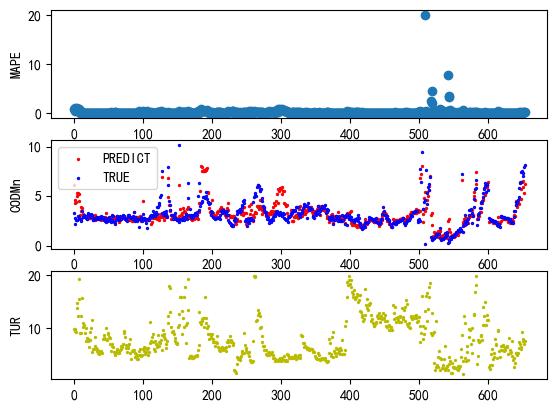

In [99]:
idx = [i for i in range(len(TUR)) if TUR[i] <= 20]
res = [res_train[i] for i in idx]
t = [target[i] for i in idx]
r = [2,4,6,10,15]
count = 0
bad_idx = []
for i in range(len(idx)):
    if t[i] <= r[1] and res[i] <= r[1]:
        count += 1
    elif r[0]<t[i] <= r[1] and r[0]<res[i] <= r[1]:
        count += 1
    elif r[1]<t[i] <= r[2] and r[1]<res[i] <= r[2]:
        count += 1
    elif r[2]<t[i] <= r[3] and r[2]<res[i] <= r[3]:
        count += 1
    elif r[3]<t[i] <= r[4] and r[3]<res[i] <= r[4]:
        count += 1
    elif r[4]<t[i] and r[4]<res[i]:
        count += 1
    elif abs(target[i] - res[i])/target[i] < 0.15:
        count += 1
    else:
        print(res[i],t[i])
        bad_idx.append(i)
        
plot(res,t,[TUR[i] for i in idx],50)
count/len(res) 

0.3519639395064877
-0.9366549037197924
0.461 0.95


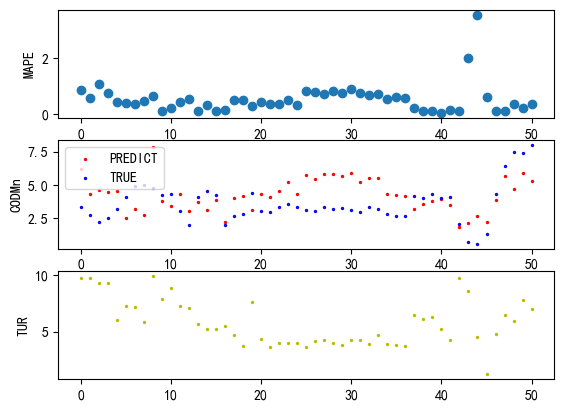

In [97]:
plot([res[i] for i in bad_idx],[t[i] for i in bad_idx],[[TUR[i] for i in idx][i] for i in bad_idx], 50)

0.1574810707614761
0.5290435125225942
0.577 0.9064748201438849


0.9014251781472684

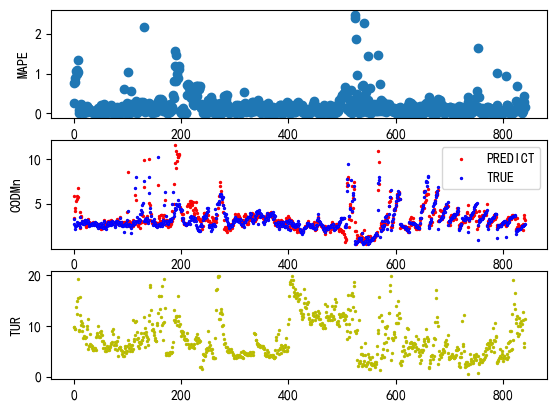

In [126]:
idx = [i for i in range(len(TUR)) if TUR[i] <= 20 and KMNO[i]>=0.5 and KMNO[i] <= 20]
res = [res_train4[i] for i in idx]
t = [target[i] for i in idx]
r = [2,4,6,10,15]
count = 0
bad_idx = []
for i in range(len(idx)):
    # if abs(target[i] - res[i])/target[i] < 0.1:
    #     count += 1
    if t[i] <= r[1] and res[i] <= r[1]:
        count += 1
    elif t[i] < r[2] and abs(target[i] - res[i]) <= 0.72:
        count += 1
    # # elif r[0]<t[i] <= r[1] and r[0]<res[i] <= r[1]:
    # #     count += 1
    elif r[1]<t[i] <= r[2] and r[1]<res[i] <= r[2]:
        count += 1
    elif r[2]<t[i] <= r[3] and r[2]<res[i] <= r[3]:
        count += 1
    elif r[3]<t[i] <= r[4] and r[3]<res[i] <= r[4]:
        count += 1
    elif r[4]<t[i] and r[4]<res[i]:
        count += 1
    elif t[i] >= r[2] and abs(target[i] - res[i])/target[i] < 0.15:
        count += 1
    else:
        # print(res[i],t[i])
        bad_idx.append(i)
        
plot(res,t,[TUR[i] for i in idx],50)
count/len(res) 

In [50]:
res = [[i1,i2,i3,i4,i5,i6] for i1,i2,i3,i4,i5,i6 in zip(res_train1,res_train2,res_train3,res_train4,res_train5,res_train6)]

0.153695135014462
0.7276223644259229
0.267 0.9090909090909091


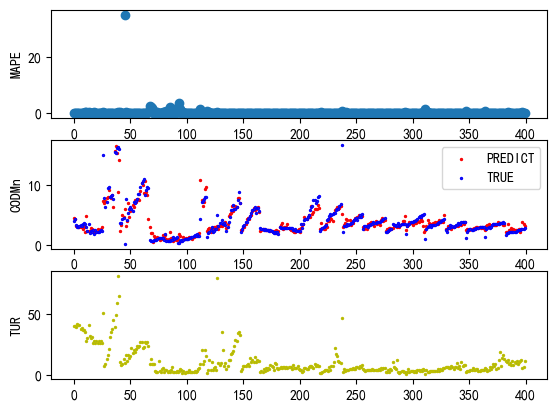

In [128]:
plot(res_train4[-400:],target[-400:],TUR[-400:],500)

0.153695135014462
0.7276223644259229
0.267 0.9090909090909091


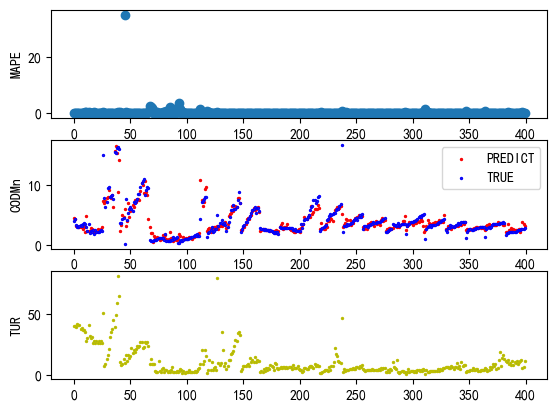

In [125]:
plot(res_train4[-400:],target[-400:],TUR[-400:],500)

In [43]:
res = [[i1,i2,i3,i4,i5,i6] for i1,i2,i3,i4,i5,i6 in zip(res_train1,res_train2,res_train3,res_train4,res_train5,res_train6)]

In [45]:
with open("models\\gaolitong_KMNO" + ".csv", "w",newline='') as f:
    write = csv.writer(f)
    for r in res:        
        write.writerow([r])